In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv ('Data/weekly_features.csv')
df = df.drop (columns = ['Unnamed: 0','USD_PHP Historical Data.csv'])
dates = df.year*100+df.week
df['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
mask = (df['Date'] >'1990-09-30') & (df['Date'] <= '2021-09-30')
df= df.loc[mask]
df = df.fillna(method='ffill')

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.to_datetime().timetuple())

# https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/
# difference dataset
diff_df=df.drop(columns=['Date', 'year', 'week'])
diff_df = diff_df.diff()
diff_df = diff_df.iloc[1:]
#diff_df['year']=df.year[1:]
#diff_df['week']=df.year[1:]
diff_df['Date']=df.Date[1:]
diff_df['Date'] = pd.to_datetime(diff_df['Date'])
# convert date to timestamp
diff_df['Date'] = diff_df['Date'].map(pd.Timestamp.timestamp)

#split the data into training and testing dataset
column_indices = {name: i for i, name in enumerate(diff_df.columns)}

n = len(diff_df)
train_df = diff_df[0:int(n*0.7)]
val_df = diff_df[int(n*0.7):int(n*0.9)]
test_df = diff_df[int(n*0.9):]

num_features = diff_df.shape[1]

#Normalize the data
from sklearn.preprocessing import MinMaxScaler
#col_list = [i for i in diff_df.columns if i != 'Date']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_val = scaler.transform(val_df)
scaled_test = scaler.transform(test_df)

In [3]:
train_df = pd.DataFrame(data = scaled_train, columns = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','Date'])
val_df = pd.DataFrame(data = scaled_val, columns = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','Date'])
test_df = pd.DataFrame(data = scaled_test, columns = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','Date'])

In [4]:
# Construct windowGenerator
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df,val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [5]:
# spit window will convert window them into a window of inputs and a window of labels. 
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels
#assgin new defined split_window function to WindowGenerator
WindowGenerator.split_window = split_window

In [17]:
# The plot function
# the parameter max_subplots defines how many time sereies stack would be presented
def plot(self, model=None, plot_col='Wheat', max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [7]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [8]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [9]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Wheat'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Wheat']

In [10]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 17)
Labels shape (batch, time, features): (32, 1, 1)


In [11]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [12]:
baseline = Baseline(label_index=column_indices['Wheat'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0738


In [13]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['Wheat'])

wide_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['Wheat']

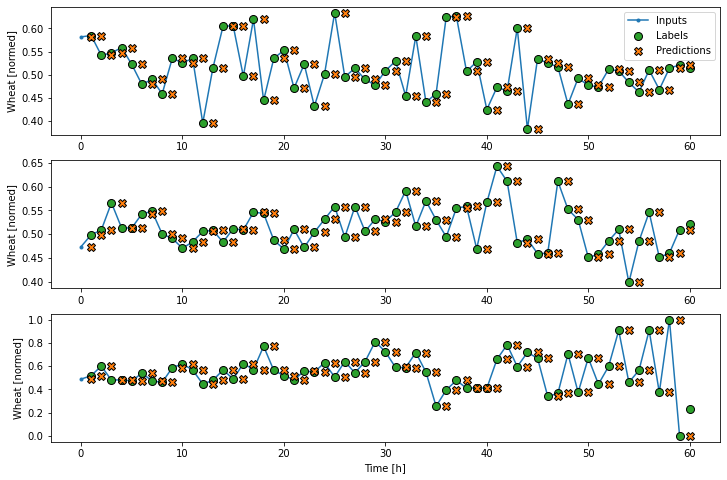

In [14]:
wide_window.plot(baseline)

In [15]:
#construct Linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [16]:
# Function of training models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [19]:
history = compile_and_fit(linear,wide_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
35/35 [==============================] - 1s 4ms/step - loss: 0.9006 - mean_absolute_error: 0.9033 - val_loss: 0.1754 - val_mean_absolute_error: 0.3559
Epoch 2/20
35/35 [==============================] - 0s 1ms/step - loss: 0.4487 - mean_absolute_error: 0.6070 - val_loss: 0.0610 - val_mean_absolute_error: 0.1920
Epoch 3/20
35/35 [==============================] - 0s 1ms/step - loss: 0.2197 - mean_absolute_error: 0.3967 - val_loss: 0.0802 - val_mean_absolute_error: 0.2343
Epoch 4/20
11/11 [==============================] - 0s 918us/step - loss: 0.1342 - mean_absolute_error: 0.3148


In [20]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 17)
Output shape: (32, 60, 1)


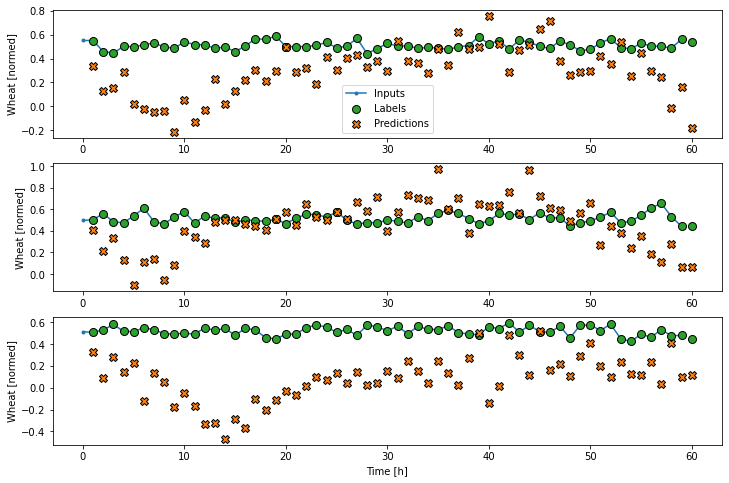

In [21]:
wide_window.plot(linear)

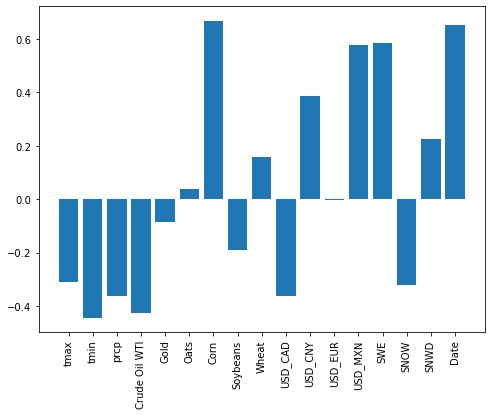

In [22]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [23]:
# Dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
36/36 [==============================] - 1s 8ms/step - loss: 0.0129 - mean_absolute_error: 0.0840 - val_loss: 0.0069 - val_mean_absolute_error: 0.0656
Epoch 2/20
36/36 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0564 - val_loss: 0.0068 - val_mean_absolute_error: 0.0655
Epoch 3/20
36/36 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0540 - val_loss: 0.0061 - val_mean_absolute_error: 0.0610
Epoch 4/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0532 - val_loss: 0.0060 - val_mean_absolute_error: 0.0600
Epoch 5/20
36/36 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0530 - val_loss: 0.0066 - val_mean_absolute_error: 0.0638
Epoch 6/20
36/36 [==============================] - 0s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0541 - val_loss: 0.0059 - val_mean_absolute_error: 0.0591
Epoch 7/20
36/36 [==========

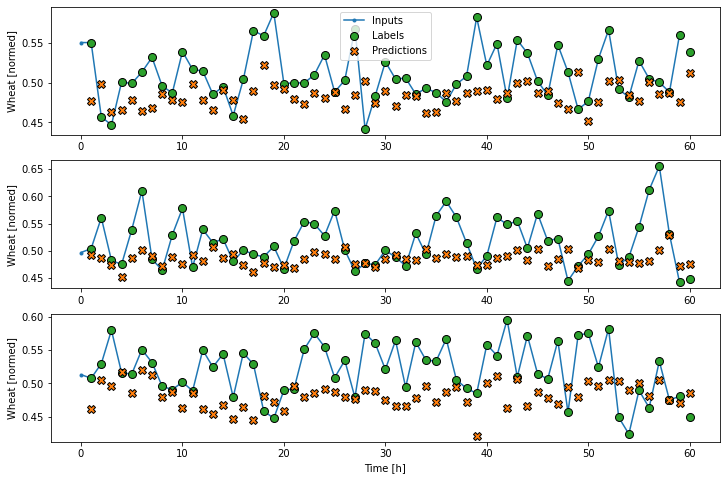

In [24]:
wide_window.plot(dense)

In [25]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Wheat'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Wheat']

In [26]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [27]:
history = compile_and_fit(multi_step_dense, conv_window)

# clear_output only leave the final output
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 700us/step - loss: 0.0083 - mean_absolute_error: 0.0729


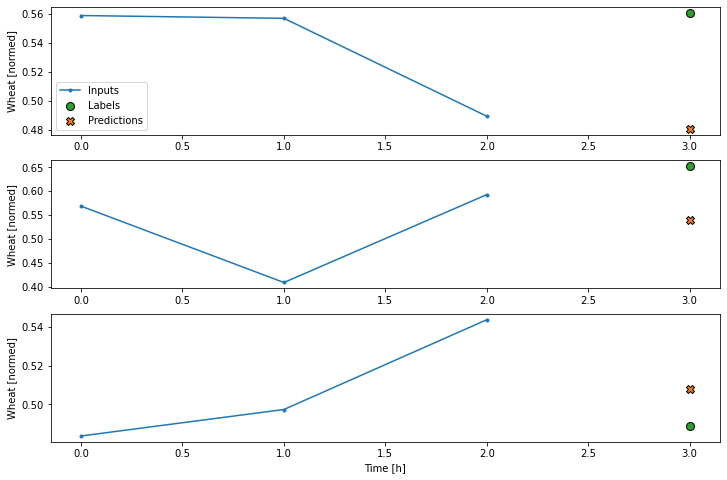

In [28]:
conv_window.plot(multi_step_dense)

In [29]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [30]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 701us/step - loss: 0.0062 - mean_absolute_error: 0.0622


In [31]:
LABEL_WIDTH = 60
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Wheat'])

wide_conv_window

Total window size: 63
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62]
Label column name(s): ['Wheat']

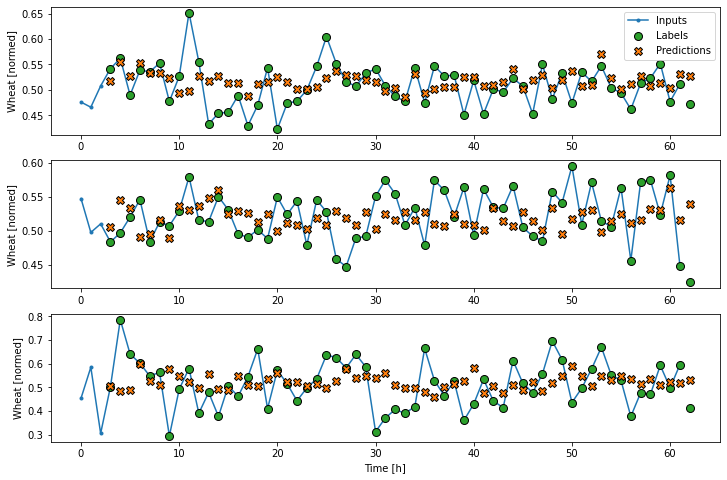

In [32]:
wide_conv_window.plot(conv_model)

In [14]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(15, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [17]:
history = compile_and_fit(lstm_model, single_step_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0592


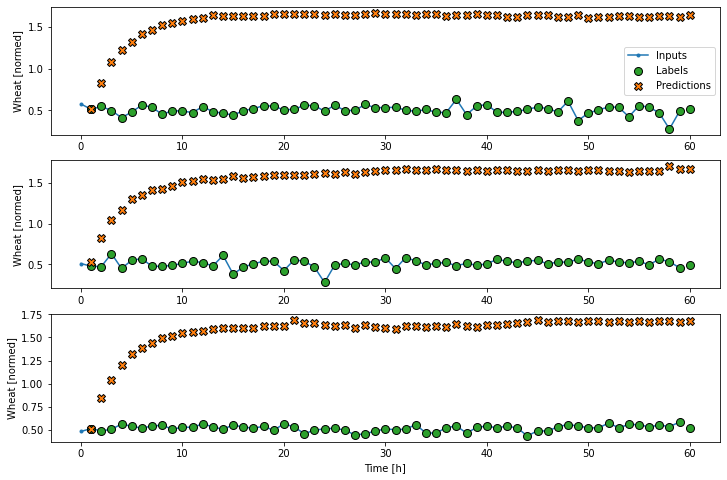

In [18]:
wide_window.plot(lstm_model)

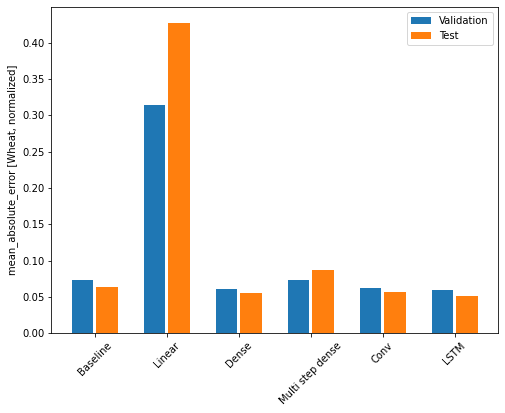

In [36]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Wheat, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

### Multi-output models

In [17]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 17)
Labels shape (batch, time, features): (32, 24, 17)


In [18]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [20]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.0157 - mean_absolute_error: 0.0793


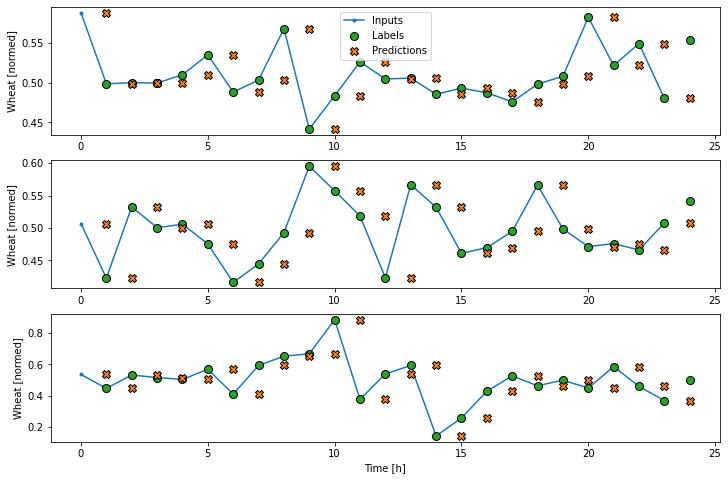

In [21]:
wide_window.plot(baseline)

### Dense

In [22]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [23]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0679


### LSTM 

In [24]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

10/10 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_error: 0.0678

CPU times: total: 44.4 s
Wall time: 15.8 s


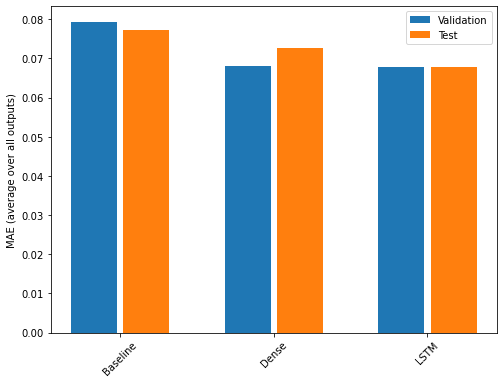

In [26]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi-step models

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24 25 26 27 28 29]
Label column name(s): None

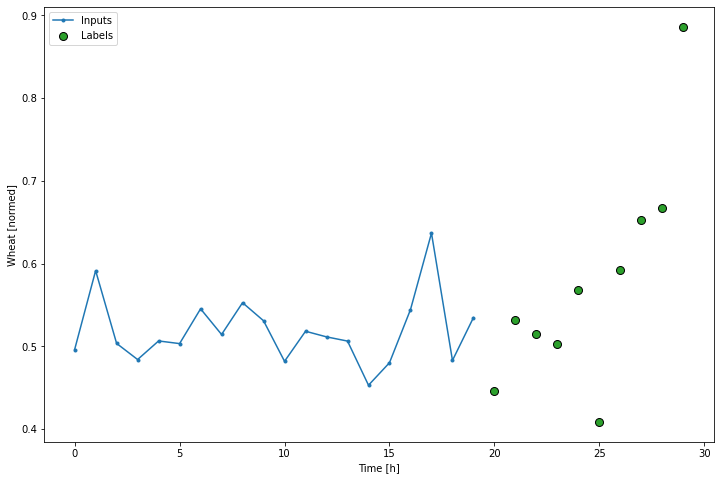

In [13]:
OUT_STEPS = 10
input_steps = 20
multi_window = WindowGenerator(input_width=input_steps,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

10/10 [==============================] - 0s 2ms/step - loss: 0.0201 - mean_absolute_error: 0.0904


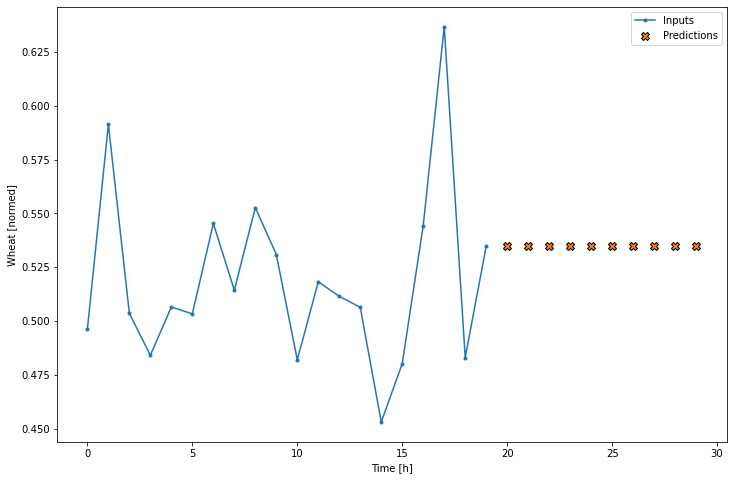

In [16]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [21]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

ValueError: in user code:

    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\engine\training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\engine\training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\engine\training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\engine\training.py", line 1501, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\wangz\Anaconda3\lib\site-packages\keras\losses.py", line 1327, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 72 and 10 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](IteratorGetNext, IteratorGetNext:1)' with input shapes: [?,72,17], [?,10,17].


8/8 [==============================] - 0s 715us/step - loss: 0.0224 - mean_absolute_error: 0.0959


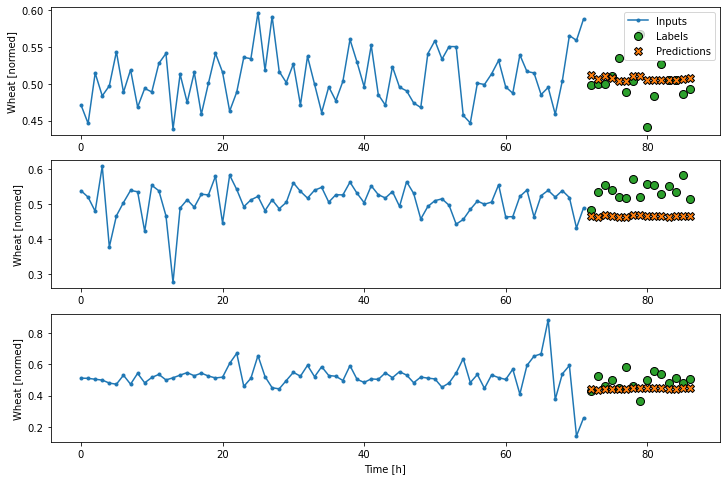

In [86]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

8/8 [==============================] - 0s 858us/step - loss: 0.0115 - mean_absolute_error: 0.0720


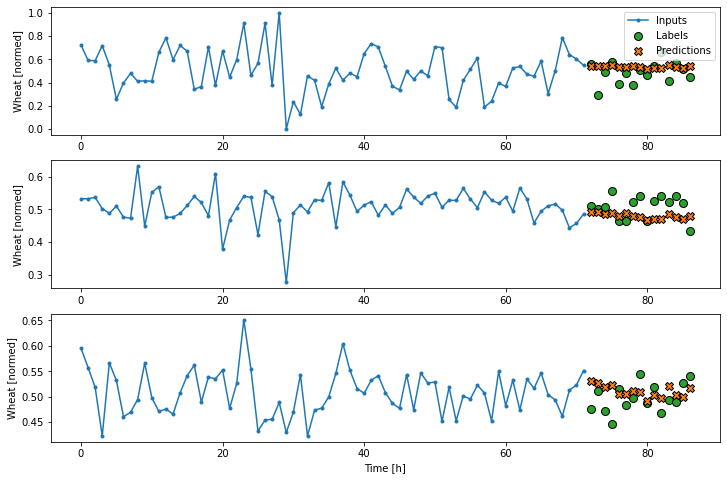

In [172]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(32, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

8/8 [==============================] - 0s 2ms/step - loss: 0.0101 - mean_absolute_error: 0.0701


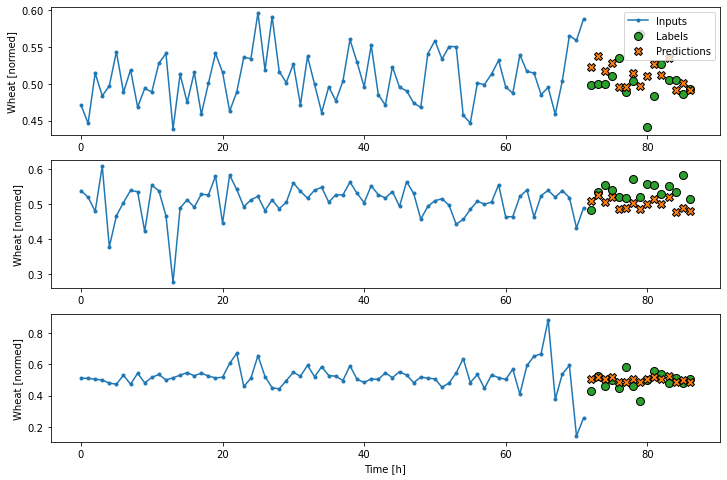

In [88]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['BiConv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['BiConv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [63]:
multi_conv_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 5, 17)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 256)            22016     
                                                                 
 dense_20 (Dense)            (None, 1, 408)            104856    
                                                                 
 reshape_5 (Reshape)         (None, 24, 17)            0         
                                                                 
Total params: 126,872
Trainable params: 126,872
Non-trainable params: 0
_________________________________________________________________


In [2]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

NameError: name 'tf' is not defined

In [61]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [90]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [62]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [91]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 17])

In [65]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

8/8 [==============================] - 0s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0765


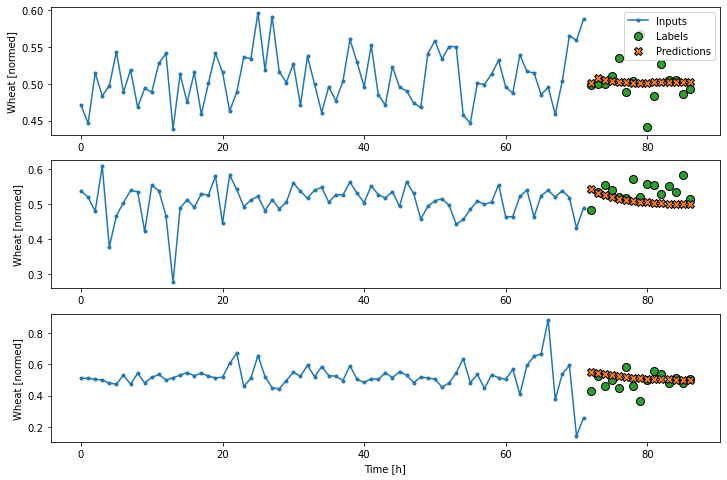

In [92]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

8/8 [==============================] - 0s 32ms/step - loss: 0.0098 - mean_absolute_error: 0.0711


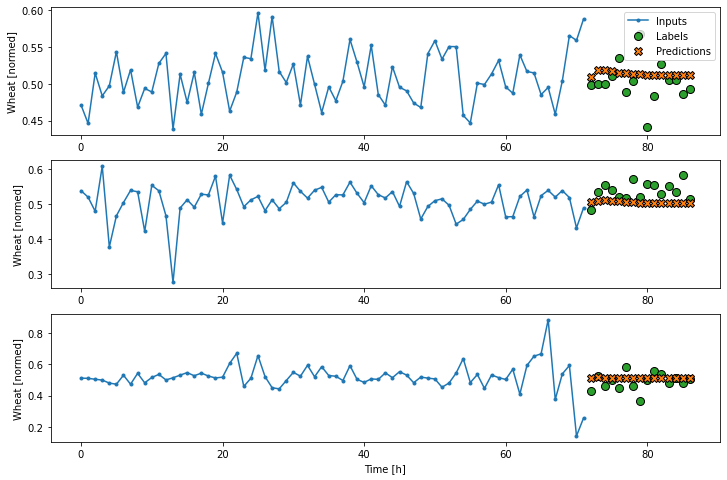

In [93]:
model_enc_dec_cnn = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(input_steps, num_features)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=11, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.RepeatVector(OUT_STEPS),
    tf.compat.v1.keras.layers.CuDNNLSTM(200, activation='relu', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_features))
])

history = compile_and_fit(model_enc_dec_cnn, multi_window)

IPython.display.clear_output()

multi_val_performance['CNN-LSTM'] = model_enc_dec_cnn.evaluate(multi_window.val)
multi_performance['CNN-LSTM'] = model_enc_dec_cnn.evaluate(multi_window.test, verbose=0)
multi_window.plot(model_enc_dec_cnn)

8/8 [==============================] - 0s 29ms/step - loss: 0.0184 - mean_absolute_error: 0.0879


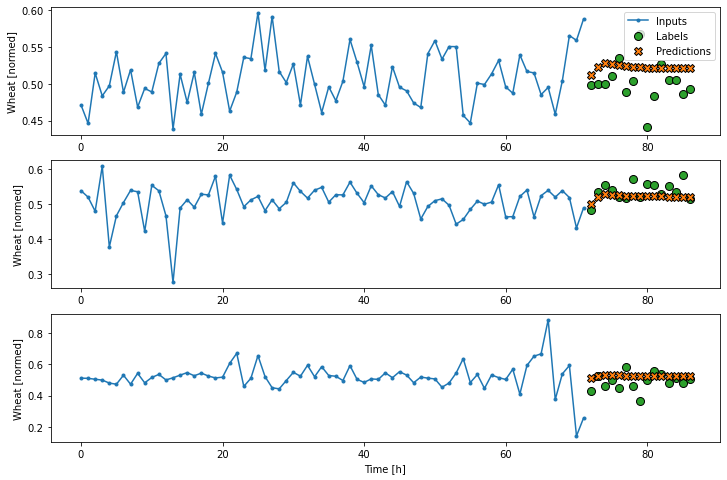

In [160]:
input_layer = tf.keras.layers.Input(shape=(input_steps, num_features)) 
head_list = []
for i in range(0, num_features):
 conv_layer_head = tf.keras.layers.Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
 conv_layer_head_2 = tf.keras.layers.Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
 conv_layer_flatten = tf.keras.layers.Flatten()(conv_layer_head_2)
 head_list.append(conv_layer_flatten)
 
concat_cnn = tf.keras.layers.Concatenate(axis=1)(head_list)
reshape = tf.keras.layers.Reshape((head_list[0].shape[1], num_features))(concat_cnn)
lstm = tf.keras.layers.LSTM(100, activation='relu')(reshape)
repeat = tf.keras.layers.RepeatVector(OUT_STEPS)(lstm)
lstm_2 = tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = tf.keras.layers.Dropout(0.2)(lstm_2)
dense = tf.keras.layers.Dense(num_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = tf.keras.models.Model(inputs=input_layer, outputs=dense)

history = compile_and_fit(multi_head_cnn_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['multi_head_cnn_lstm_model'] = multi_head_cnn_lstm_model.evaluate(multi_window.val)
multi_performance['multi_head_cnn_lstm_model'] = multi_head_cnn_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_head_cnn_lstm_model)

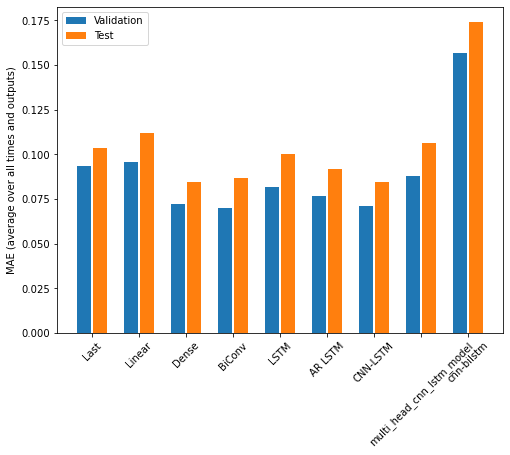

In [173]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [95]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.1035
Linear  : 0.1119
Dense   : 0.0816
BiConv  : 0.0866
LSTM    : 0.1004
AR LSTM : 0.0919
CNN-LSTM: 0.0844
